In [39]:
import sys  
sys.path.insert(0, './../')
import numpy as np
import bbdc2021 as bbdc
import pandas as pd
from importlib import reload
reload(bbdc)
import tensorflow as tf
from keras import layers
import keras
from keras import backend as K
from itertools import groupby
import matplotlib.pyplot as plt
from matplotlib import colors 
import models.cnn.u_net_1d as unet
reload(unet)
import models.cnn.lessParameter_u_net_1d as lpUnet
reload(lpUnet)
import evaluation.evaluate as evaluate

In [8]:
np.random.seed(1)
tf.random.set_seed(1)

In [9]:
pathToDataset = "dataset_fft_l1024_o523_b4/"
X_train, Y_train, timepoints, trainFileList = bbdc.load_data("train.csv", pathToDataset)
X_validation, Y_validation, timepoints, validationFileList = bbdc.load_data("validation.csv", pathToDataset)  
X_test, Y_test, timepoints, testFileList = bbdc.load_data("test.csv", pathToDataset)

inputShape = X_train[0].shape

In [1]:
print(tf.__version__)

2.4.1


In [18]:
channels = [32, 64, 90]
model = lpUnet.lessParameter_u_net(inputShape, channels)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 320, 129)]   0                                            
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 320, 32)      4160        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_10 (BatchNo (None, 320, 32)      128         conv1d_11[0][0]                  
__________________________________________________________________________________________________
re_lu_10 (ReLU)                 (None, 320, 32)      0           batch_normalization_10[0][0]     
____________________________________________________________________________________________

In [ ]:
#Mit crossentropy
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['mae', 'accuracy'])
history = model.fit(X_train,Y_train, batch_size=15, epochs=7, validation_data=(X_validation, Y_validation))

In [8]:
#Mit Dice
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss=bbdc.dice_loss, metrics=['mae', 'accuracy'])
history = model.fit(X_train,Y_train, batch_size=15, epochs=30, validation_data=(np.array(X_validation), np.array(Y_validation)))

Epoch 1/25
534/534 [==============================] - 9s 18ms/step - loss: 0.0824 - mae: 0.0270 - accuracy: 0.8597 - val_loss: 0.1570 - val_mae: 0.0491 - val_accuracy: 0.7272
Epoch 2/25
534/534 [==============================] - 9s 18ms/step - loss: 0.0783 - mae: 0.0256 - accuracy: 0.8666 - val_loss: 0.2714 - val_mae: 0.0779 - val_accuracy: 0.5334
Epoch 3/25
534/534 [==============================] - 10s 18ms/step - loss: 0.0740 - mae: 0.0242 - accuracy: 0.8741 - val_loss: 0.4289 - val_mae: 0.1102 - val_accuracy: 0.2892
Epoch 4/25
534/534 [==============================] - 10s 18ms/step - loss: 0.0715 - mae: 0.0233 - accuracy: 0.8783 - val_loss: 0.1611 - val_mae: 0.0462 - val_accuracy: 0.7256
Epoch 5/25
534/534 [==============================] - 10s 19ms/step - loss: 0.0682 - mae: 0.0222 - accuracy: 0.8843 - val_loss: 0.2628 - val_mae: 0.0730 - val_accuracy: 0.5525
Epoch 6/25
534/534 [==============================] - 10s 18ms/step - loss: 0.0660 - mae: 0.0215 - accuracy: 0.8877 - val_

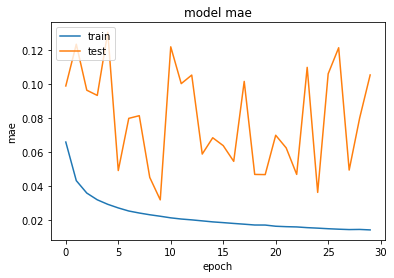

In [12]:
# summarize history for mae
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

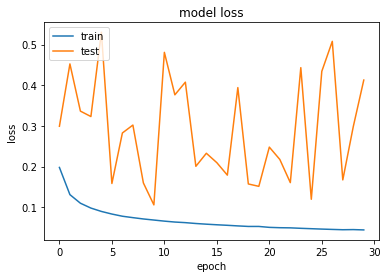

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [29]:
prediction = model.predict(X_test)
discretePrediction = (prediction == prediction.max(axis=1)[:,None]).astype(int)

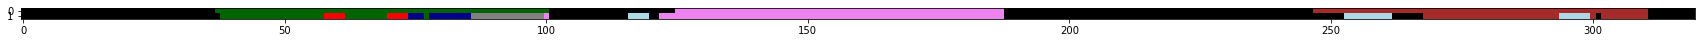

In [50]:
bbdc.plotPredictionAndGT(Y_test, prediction, 0)

In [35]:
scores = model.evaluate(X_test, Y_test)


32/32 [==============================] - 0s 10ms/step - loss: 0.1478 - mae: 0.0437 - accuracy: 0.7411


In [42]:
df = bbdc.getPredictionAsSequenceDF(prediction, timepoints, testFileList)
df.to_csv("LP1d_Prediction.csv", index=False)
df.head()
evaluate.evaluate("LP1d_Prediction.csv", "./../data/test.csv")

(0.047200148913397556, 'Valid file')